

# ECG Data Compressive Sensing
    :depth: 2
    :local:

In this example, we demonstrate the compressive sensing of ECG data
and reconstruction using Block Sparse Bayesian Learning (BSBL).


In [ ]:
# # Configure JAX to work with 64-bit floating point precision. 
# from jax.config import config
# config.update("jax_enable_x64", True)

ModuleNotFoundError: No module named 'jax.config'

Let's import necessary libraries



In [ ]:
import timeit
import jax 
import numpy as np
import jax.numpy as jnp
# CR-Suite libraries
import cr.nimble as crn
import cr.nimble.dsp as crdsp
import cr.sparse.dict as crdict
import cr.sparse.plots as crplot
import cr.sparse.block.bsbl as bsbl

# Sample data
from scipy.datasets import electrocardiogram
# Plotting
import matplotlib.pyplot as plt
# Miscellaneous
from scipy.signal import detrend, butter, filtfilt

## Test signal
SciPy includes a test electrocardiogram signal
which is a 5 minute long electrocardiogram (ECG), 
a medical recording of the electrical activity of the heart, 
sampled at 360 Hz.



In [25]:
import mne

raw = mne.io.read_raw_edf('/home/jplp/Disco X/UFMG/2025/TCC/Códigos/eeg_cs/files/CHBMIT/chb07/chb07_02.edf')


# (n_samples, n_channels)
data = raw.get_data().T[:, :-1]

Extracting EDF parameters from /home/jplp/Disco X/UFMG/2025/TCC/Códigos/eeg_cs/files/CHBMIT/chb07/chb07_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_10732/1672691760.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf('/home/jplp/Disco X/UFMG/2025/TCC/Códigos/eeg_cs/files/CHBMIT/chb07/chb07_02.edf')


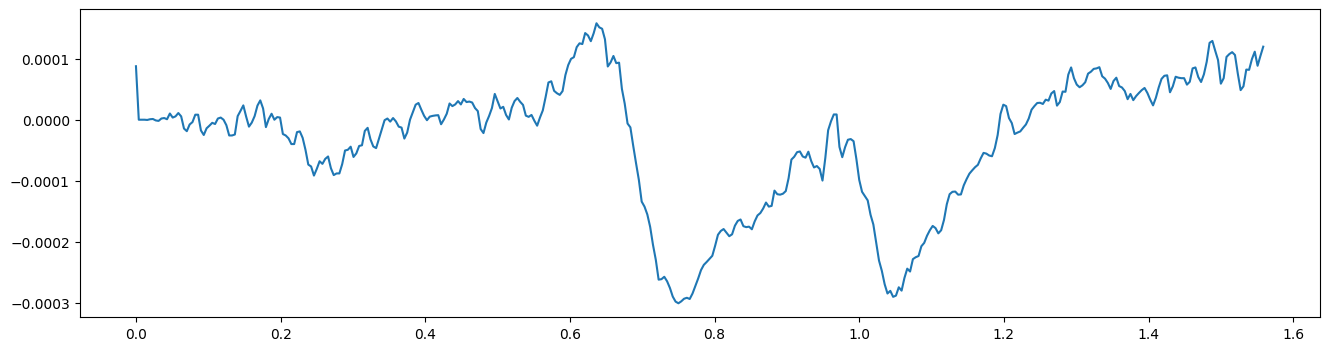

In [33]:
# Sampling frequency in Hz
fs = 256
# We shall only process a part of the signal in this demo
N = 400
x = data[:N, 0]  # Take the first channel and the first N samples
t = np.arange(N) * (1/fs)
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(t, x);

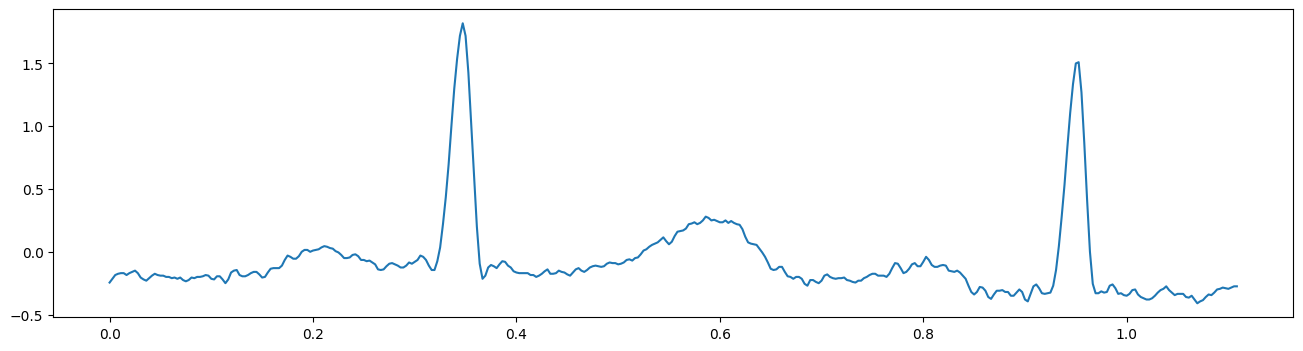

In [32]:
ecg = electrocardiogram()
# Sampling frequency in Hz
fs = 360
# We shall only process a part of the signal in this demo
N = 400
x = ecg[:N]
t = np.arange(N) * (1/fs)
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(t, x);

### Preprocessing



In [1]:
# # Remove the linear trend from the signal
# x = detrend(x)
# ## bandpass filter
# # lower cutoff frequency
# f1 = 5
# # upper cutoff frequency
# f2 = 40
# # passband in normalized frequency
# Wn = np.array([f1, f2]) * 2 / fs
# # butterworth filter
# fn = 3
# fb, fa = butter(fn, Wn, 'bandpass')
# x = filtfilt(fb,fa,x)
# fig, ax = plt.subplots(figsize=(16,4))
# ax.plot(t, x);

## Compressive Sensing at 70%
We choose the compression ratio (M/N) to be 0.7



In [44]:
CR = 0.5
M = int(N * CR)
print(f'M={M}, N={N}, CR={CR}')

M=200, N=400, CR=0.5


Sensing matrix



In [45]:
Phi = crdict.gaussian_mtx(crn.KEY0, M, N)

### Measurements



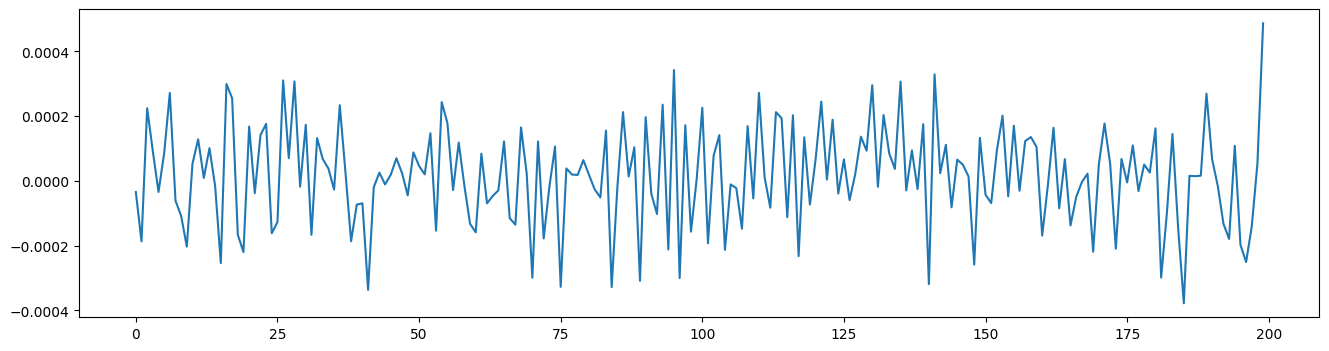

In [46]:
y = Phi @ x
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(y);

### Sparse Recovery with BSBL



In [63]:
options = bsbl.bsbl_bo_options(y, max_iters=100)
start = timeit.default_timer()
sol = bsbl.bsbl_bo_np_jit(Phi, y, 80, options=options)
stop = timeit.default_timer()
print(f'Reconstruction time: {stop - start:.2f} sec', )
print(sol)

Reconstruction time: 0.46 sec
iterations=97
block size=80
blocks=5, nonzero=5
r_norm=1.40e-04
x_norm=2.16e-03
lambda=4.35e-10
dmu=1.00e-08


Recovered signal



In [64]:
x_hat = sol.x
print(f'SNR: {crn.signal_noise_ratio(x, x_hat):.2f} dB, PRD: {crn.percent_rms_diff(x, x_hat):.1f}%')

SNR: 19.03 dB, PRD: 11.2%


Plot the original and recovered signals



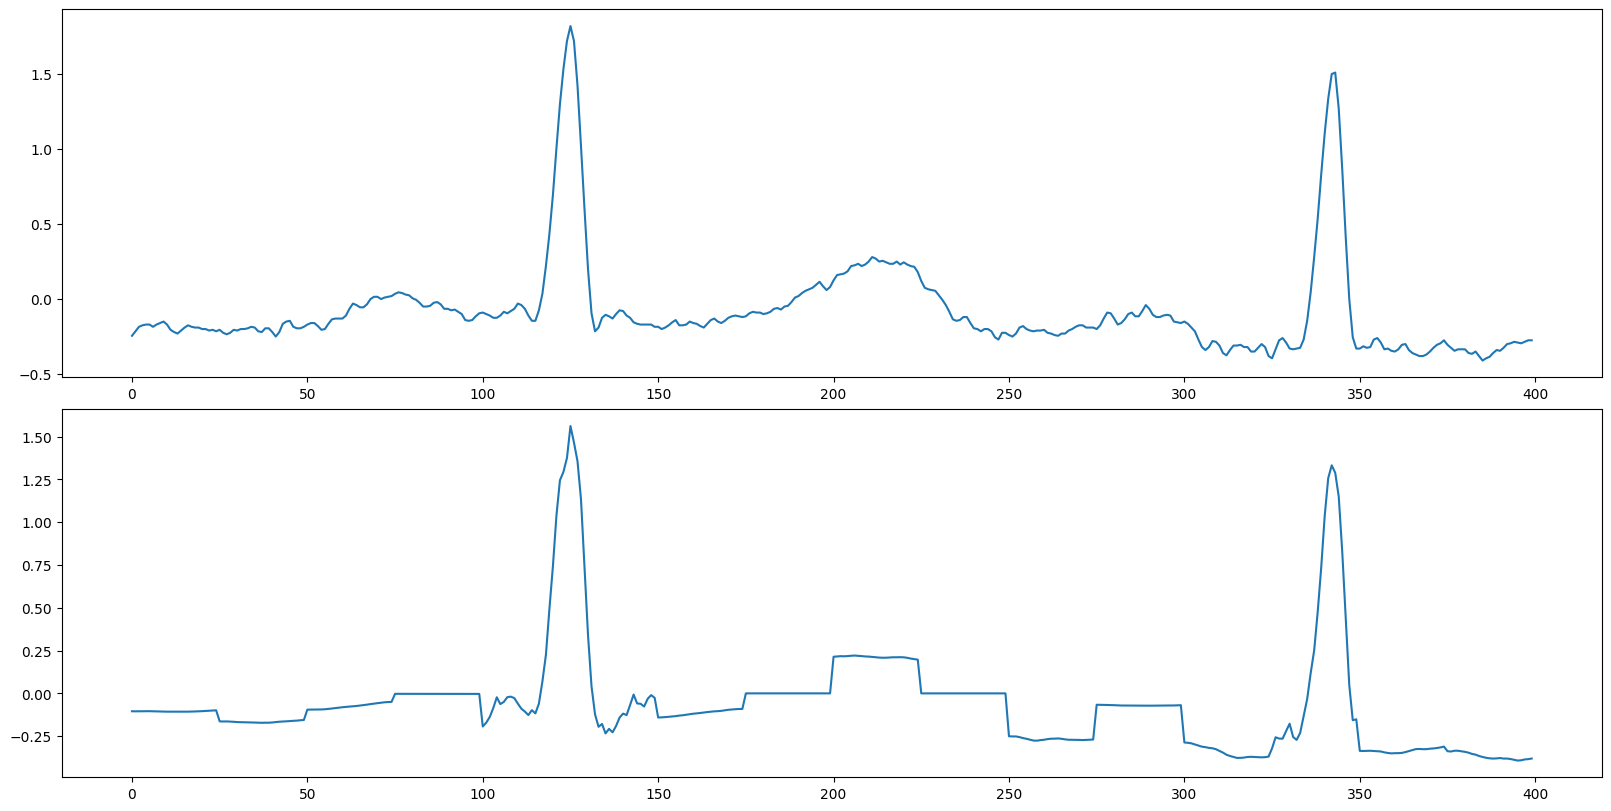

In [23]:
ax = crplot.h_plots(2)
ax[0].plot(x)
ax[1].plot(x_hat)

## Compressive Sensing at 50%
Let us now increase the compression



In [11]:
CR = 0.50
M = int(N * CR)
print(f'M={M}, N={N}, CR={CR}')

M=200, N=400, CR=0.5


Sensing matrix



In [12]:
Phi = crdict.gaussian_mtx(crn.KEY0, M, N)

### Measurements



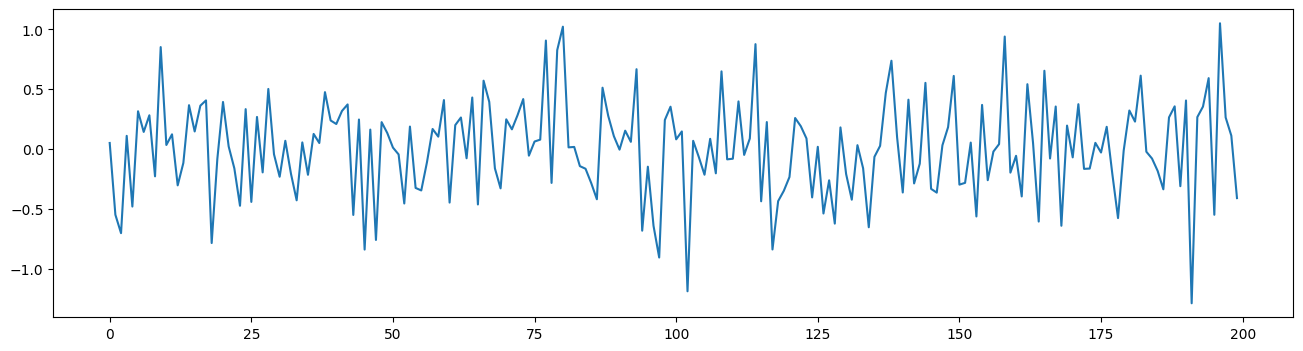

In [13]:
y = Phi @ x
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(y);

### Sparse Recovery with BSBL



In [14]:
options = bsbl.bsbl_bo_options(y, max_iters=20)
start = timeit.default_timer()
sol = bsbl.bsbl_bo_np_jit(Phi, y, 25, options=options)
stop = timeit.default_timer()
print(f'Reconstruction time: {stop - start:.2f} sec', )
print(sol)

Reconstruction time: 0.92 sec
iterations=20
block size=25
blocks=16, nonzero=16
r_norm=2.14e-01
x_norm=5.24e+00
lambda=2.18e-03
dmu=1.29e-02


Recovered signal



In [15]:
x_hat = sol.x
print(f'SNR: {crn.signal_noise_ratio(x, x_hat):.2f} dB, PRD: {crn.percent_rms_diff(x, x_hat):.1f}%')

SNR: 22.12 dB, PRD: 7.8%


Plot the original and recovered signals



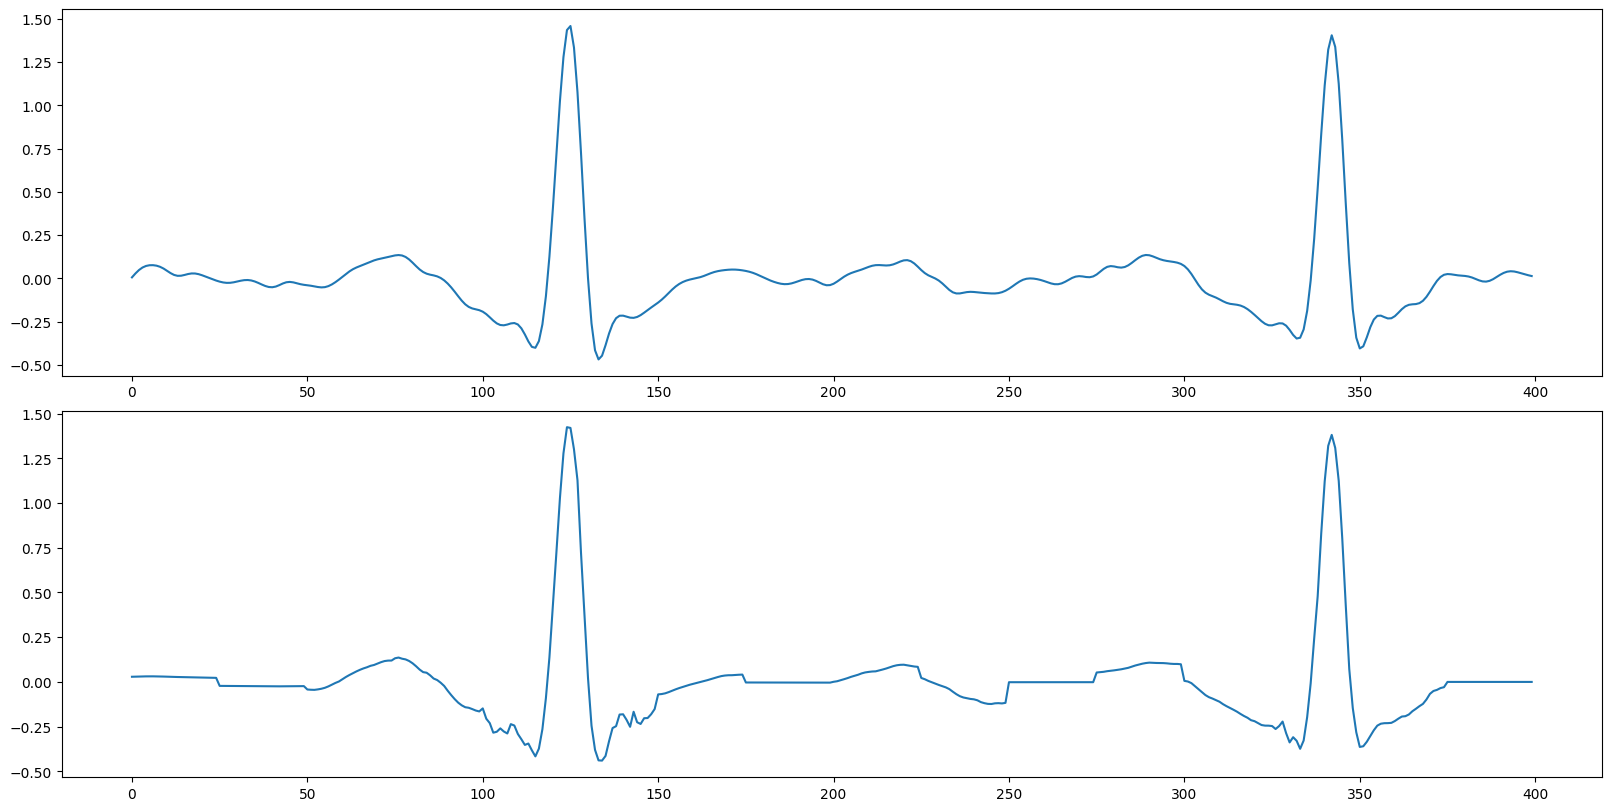

In [16]:
ax = crplot.h_plots(2)
ax[0].plot(x)
ax[1].plot(x_hat)